# Natural Language Processing

## Final Project

Team:\
Prabin Raj Shrestha\
Neha Reddy Gaddam\
Shivani Agarwal


---
---


# Transformer Summarizer

Explore summarization using the transformer model.
We will implement the transformer decoder from scratch, but we will slowly walk you through it. There are many hints in this notebook so feel free to use them as needed.

<img src = 'https://docs.google.com/uc?export=download&id=1H60sdmeFM0HHBREeBmMZ4ieVGcr4q5hi'>
<!-- <img src = "files/transformerNews.png"> -->


---

<a name='0'></a>
### Introduction

Text Summarization is the process of creating a summary of a certain document that contains the most important information of the original one, the purpose of it is to get a summary of the main points of the document. Text summarization has become increasingly important due to the vast amount of data available today. Extractive and abstractive are the main approaches used to create summaries. Extractive summarization has matured, and research has shifted towards abstractive and real-time summarization

Abstractive summarization creates a shorter summary of text by generating new sentences that convey the same meaning as the original text. It uses natural language generation techniques to produce high-quality summaries that retain essential information while maintaining readability. It is particularly useful for large amounts of data, but more challenging than extractive summarization. Abstractive summarization of multi-documents aims to distill the most important ideas while keeping the summary concise and coherent.

We would be exploring the below

- Use built-in functions to preprocess your data
- Implement DotProductAttention
- Implement Causal Attention
- Know how attention functions
- Build transformer model
- Evaluate your model
- Summarize an article

Our model will be heavily based on attention and does not rely on sequences, which allows for parallel computing.

---

# Reference Papers & Codes:

Paperswithcode: https://paperswithcode.com/sota/abstractive-text-summarization-on-cnn-daily

## Papers:


* Abstractive Text Summarization using Sequence-to-sequence
RNNs and Beyond
https://arxiv.org/pdf/1602.06023v5.pdf

* Attention is all you need:
https://arxiv.org/abs/1706.03762

* Transformer Based Implementation for Automatic Book Summarization:
https://ijisae.org/index.php/IJISAE/article/view/2421

## Articles:

* Abstractive Text Summarization Using Transformers: https://medium.com/swlh/abstractive-text-summarization-using-transformers-3e774cc42453

* Get started with Google Trax for NLP: https://towardsdatascience.com/get-started-with-google-trax-for-nlp-ff8dcd3119cf

## Online Courses:

* Coursera Deep Learning Specialization by Andrew Ng https://www.coursera.org/specializations/deep-learning


---

# Installing and Importing Packages

Packages used:

sys: https://docs.python.org/3/library/sys.html \
os: https://docs.python.org/3/library/os.html \
numpy: https://numpy.org/doc \
textwrap: https://docs.python.org/3/library/textwrap.html \
trax: https://trax-ml.readthedocs.io/en/latest/ \


In [2]:
from google.colab import output as colab_output

## Installing Packages

In [3]:
# trax
!pip install trax

colab_output.clear()

In [4]:
import sys #system
import os #os to run os commands
import shutil # shutil
import zipfile # to zip file

import numpy as np #numpy
import pandas as pd #pd

import textwrap
wrapper = textwrap.TextWrapper(width=70)

import trax
from trax.fastmath import numpy as jnp
from trax import layers as tl

import re

# nltk
import nltk

# Downloading nltk resources
nltk.download('punkt')
nltk.download('wordnet') # for lemma
nltk.download('omw-1.4') # for lemma
nltk.download('stopwords') # stopwords

# Importing Regex Tokenizer from nltk
from nltk.tokenize import RegexpTokenizer

# Importing Tree bank Word Tokenizer from nltk
from nltk.tokenize import TreebankWordTokenizer

# Downloading Model
from google.colab import files

# requests
import requests

# to print the entire np array
np.set_printoptions(threshold=sys.maxsize)

# To diplay Youtube videos
from IPython.display import YouTubeVideo as YT_V


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Custom functions

In [ ]:
# Custom functions

# Function to create a directory and its parent directories if they do not exist.
def create_directory(path):
  """
  Recursively create a directory and its parent directories if they do not exist.
  """
  if not os.path.exists(path):
    # Recursively create the parent directory if it does not exist
    if not os.path.exists(os.path.dirname(path)):
        create_directory(os.path.dirname(path))
    # Create the directory
    os.mkdir(path)


def zip_folder(folder_path, output_path):
  """Create a zip archive of the given folder."""
  with zipfile.ZipFile(output_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(folder_path):
      for file in files:
        file_path = os.path.join(root, file)
        zipf.write(file_path, os.path.relpath(file_path, folder_path))


# Zip and Download
def zip_n_dl(folder_dir):
  zip_folder(folder_dir, f'{folder_dir}.zip')
  files.download(f'{folder_dir}.zip')

# Unzip a file
def unzip_file(zip_file_path, extract_to_path = None):
  """Extract the contents of the given zip file to the specified directory."""
  extract_to_path = str(zip_file_path).split('.zip')[0] if extract_to_path is None else extract_to_path
  with zipfile.ZipFile(zip_file_path, "r") as zipf:
    zipf.extractall(extract_to_path)


def df_pkl_n_dn(df, pkl_file_dir):
  df.to_pickle(f'{pkl_file_dir}.pkl')
  files.download(f'{pkl_file_dir}.pkl')



<a name='1'></a>
# Part 1: Importing the dataset

Trax makes it easy to work with Tensorflow's datasets:

In [ ]:
# !rm -rf data
# !rm -rf sample_data

In [ ]:
!mkdir 'data'

In [ ]:
# Downliading File
!wget 'https://docs.google.com/uc?export=download&id=1FSyO2pB2Aw7rqvogIYZQPBOy6gvQYzdf&confirm=t' -O 'cnn_dailymail.zip'
# Unzipping File
!unzip -o 'cnn_dailymail.zip' -d 'data'
# Removing after unzipping
!rm cnn_dailymail.zip

colab_output.clear()
print('Data Load successful!')

Data Load successful!


In [ ]:
# Vocab
# Downliading File
!wget 'https://docs.google.com/uc?export=download&id=1FWJuKOMjiGHJhwjcpSoarnZ3l7jpBOKh&confirm=t' -O 'vocabs.zip'
# Unzipping File
!unzip -o 'vocabs.zip' -d 'data'
# Removing after unzipping
!rm vocabs.zip

colab_output.clear()
print('Data Load successful!')

Data Load successful!


In [ ]:
# Loading data

# Test and train

train_data_df = pd.read_csv('data/cnn_dailymail/train.csv')
test_data_df = pd.read_csv('data/cnn_dailymail/test.csv')

train_data_df.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


---

<a name='1.1'></a>
## 1.1 Preprocessing

Applying preprocessing

In [ ]:
# Custom Tree bank Word Tokenizer
# This is used to tokenize the document
class custom_tbw:
  def __init__(self):
     self.re_period_pattern = re.compile('\w+\.$')
     treebankword_tokenize = TreebankWordTokenizer()
     self.treebankword_tokenizer = treebankword_tokenize.tokenize

  def tokenizer(self, input_text):
    pre_token = self.treebankword_tokenizer(input_text)
    out_token = []

    for token in pre_token:
      if self.re_period_pattern.match(token): # Checking if the word ends with .
        out_token.append(token[:-1]) # Appending the word
        out_token.append(token[-1]) # Adding the period at the end
      else:
        out_token.append(token)
    # Returning output
    return out_token

# Preprocessing steps
# This is used to clean the text
class custom_text_processing(custom_tbw):
  def __init__(self):
    super().__init__()
    self._def_init__()

  def _def_init__(self):
    # Negationwords
    self.negationwords = ['no', 'not', 'never', 'none', 'nowhere', 'nothing', 'noone', 'rather', 'hardly', 'scarcely', 'rarely', 'seldom', 'neither', 'nor', 'ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn']
    # Stopwords
    self.sw_l = nltk.corpus.stopwords.words('english')
    self.sw_l = [sw for sw in self.sw_l if sw not in self.negationwords]
    # Unwanted punctuation
    self.punctuation_l = ['.', ',', '--', '"', "'"]
    # making a stop word dictionary
    self.sw_dict = {sw.lower():False for sw in self.sw_l}
    # making a stop word dictionary
    self.punt_dict = {sw.lower():False for sw in self.punctuation_l}
    # Wordnet lemmantizer:
    self.wnl = nltk.WordNetLemmatizer()
    # stop_wl_pattern
    self.stop_pat = r'\b(?:{})\b'.format('|'.join(self.sw_l))

  def ReturnCleanText(self, text):
    # Lower casing the text
    text = text.lower()

    # Substituting anything between words using reguler expression and substituting it with ' '
    text = re.sub(r"\W+|_", ' ', text)

    # removing stop words
    return re.sub(self.stop_pat, '', text)


  # Function to tokenize
  def text_tokenization(self, in_text):
    return self.tokenizer(in_text)

  # Function to lower case the tokens:
  def lower_case_tokens(self, in_token):
    return [t.lower() for t in in_token]

  # Lemmantize tokens
  def wnl_lemmatize(self, in_token):
    return [self.wnl.lemmatize(token) for token in in_token]

  # function to check stop words
  def is_not_sw(self, in_token):
    return self.sw_dict.get(in_token.lower(),True)

  # function to check punctuation
  def is_not_punct(self, in_token):
    return self.punt_dict.get(in_token.lower(),True)

  # making a function that removes stop word
  def remove_stopwords(self, in_token):
    return [token for token in in_token if self.is_not_sw(token.lower())]

  def remove_punctuation(self, in_token):
    return [token for token in in_token if self.is_not_punct(token.lower())]

  def clean_text_processing(self, in_text):
    text = self.ReturnCleanText(in_text)
    # Tokenize the text
    tokens = self.text_tokenization(text)
    # Lower case
    tokens = self.lower_case_tokens(tokens)
    # lemmantize
    tokens = self.wnl_lemmatize(tokens)
    # # Remove stop words
    # tokens = self.remove_stopwords(tokens)
    # # Remove punctuation
    # tokens = self.remove_punctuation(tokens)

    # Output
    out_text = ' '.join(tokens)
    return out_text


<>:5: DeprecationWarning: invalid escape sequence '\w'


In [ ]:
# Pulling the resource to process the text

# Text Processor
text_processer = custom_text_processing()
# clean text processor
clean_text_processor = text_processer.clean_text_processing

def bytfy(x:str):
  return bytes(x, 'utf-8')

# process text:
def process_text(x:str):
  t = clean_text_processor(x)
  return bytfy(t)

In [ ]:
# Downloading porcessed data
!wget 'https://docs.google.com/uc?export=download&id=1HI920sXIQ6aVlhiE14RDqtbpU_ZB5usI&confirm=t' -O 'processed_train_data_df.pkl'
!wget 'https://docs.google.com/uc?export=download&id=1HE9lojnHfpTiTJrT9xj4VtpSLG3tD6Rm&confirm=t' -O 'processed_test_data_df.pkl'


colab_output.clear()

In [ ]:
# Preporcessing 1

process_data_f = False

if process_data_f:
  '''If we want to process the data'''

  # Rename columns
  rename_col_dict = {'article': 'text', 'highlights': 'summary'}

  processed_train_data_df = train_data_df.rename(columns=rename_col_dict)
  processed_test_data_df = test_data_df.rename(columns=rename_col_dict)

  # applying bytes on training data
  processed_train_data_df['text'] = processed_train_data_df['text'].apply(lambda x: process_text(str(x)))
  processed_train_data_df['summary'] = processed_train_data_df['summary'].apply(lambda x: bytfy(str(x)))

  # applying bytes on test data
  processed_test_data_df['text'] = processed_test_data_df['text'].apply(lambda x: process_text(str(x)))
  processed_test_data_df['summary'] = processed_test_data_df['summary'].apply(lambda x: bytfy(str(x)))

else:
  processed_train_data_df = pd.read_pickle('processed_train_data_df.pkl')
  processed_test_data_df = pd.read_pickle('processed_test_data_df.pkl')

# Preview
processed_train_data_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,text,summary
0,0001d1afc246a7964130f43ae940af6bc6c57f01,b'associated press published 14 11 est 25 octo...,"b'Bishop John Folda, of North Dakota, is takin..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,b'cnn ralph mata internal affair lieutenant mi...,b'Criminal complaint: Cop used his role to hel...
2,00027e965c8264c35cc1bc55556db388da82b07f,b'drunk driver killed young woman head crash c...,"b""Craig Eccleston-Todd, 27, had drunk at least..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,b'cnn breezy sweep pen president vladimir puti...,"b""Nina dos Santos says Europe must be ready to..."
4,0003ad6ef0c37534f80b55b4235108024b407f0b,b'fleetwood team still 100 record sky bet leag...,b'Fleetwood top of League One after 2-0 win at...


In [ ]:
if process_data_f:
  df_pkl_n_dn(processed_train_data_df, 'processed_train_data_df')
  df_pkl_n_dn(processed_test_data_df, 'processed_test_data_df')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

Making Text stream

In [ ]:
def data_stream(data_df, n:int = 0, col_n:dict={'text': 'text', 'summary':'summary'}):
  c = 0
  for index, row in data_df.iterrows():
    c += 1
    if n != 0 and c>n:
        break
    yield row[col_n['text']], row[col_n['summary']]

In [ ]:
# making a text stream for training
train_stream_fn = data_stream(processed_train_data_df)

test_stream_fn = data_stream(processed_test_data_df)

In [ ]:
# Test

test_text, test_summary = next(test_stream_fn)

print(test_text)
print('')
print(test_summary)

---

<a name='1.1'></a>
## 1.2 Tokenize & Detokenize helper functions

Just like in the previous assignment, the cell above loads in the encoder for you. To work with any dataset, it's important to have the ability to link words to their numerical indices, and vice versa. Trax models typically use numeric tensors as input and output, where each numeric value corresponds to a particular word.

In order to translate text into numerical values that can be processed by a computer, we can utilize the following tools:

* word2Ind: a dictionary that links each word to its corresponding index number.
* ind2Word: a dictionary that links each index number to its corresponding word.
* word2Count: a dictionary that links each word to the number of times it appears in the text.
* num_words: the total number of words that appear in the text.

These step have been implemented several times in previous assignments and labs, we will use helper functions that will do this for us. Below are the functions:

* Tokenize: Tokenize refers to the process of transforming a textual sentence into a token list, which is essentially a list of indices. This conversion also involves breaking down words into smaller subwords.

* Detokenize: On the other hand, detokenize involves the reverse process of converting a token list back into its corresponding sentence, essentially creating a string of text from the list of indices.

In [ ]:
def tokenizer(input_str, EOS=1):
    # Tokenizing Input strings in text to features dict,
    # To tokenize data in Trax, we can use the trax.data.tokenize method. This method works with streams as input and output.
    # However, to bypass this limitation, we can create a unigram stream using the iter function.
    # The summarize32k.subword.subwords is a large list of words
    inputs =  next(trax.data.tokenize(iter([input_str]),vocab_dir='data/vocabs/',vocab_file='summarize32k.subword.subwords'))

    # Add the EOS symbol to signify the conclusion of the sentence.
    return list(inputs) + [EOS]

def detokenizer(integers):
    # List of ints (tokenized sentence) to string
    s = trax.data.detokenize(integers,vocab_dir='data/vocabs/',vocab_file='summarize32k.subword.subwords')
    return wrapper.fill(s)


test_s = 'We will be using Transformer, encoder, and Decoder to make a text summarization'


tokens=tokenizer(test_s)
print(tokens)
print(test_s,'\n')
print(detokenizer(tokens))

<a name='1.2'></a>

## 1.3 Preprocessing for Language Models: Concatenate It!

As we know language models predict the next word, they have no notion of inputs. To create a single input suitable for a language model, we concatenate inputs with targets putting a separator in between.

We also need to create a mask -- with 0s at inputs and 1s at targets -- to avoid panalizing the model for mis predicting. This way the model is not penalized for mis-predicting the article and only focuses on the summary.

In [ ]:
# Special tokens
sep = 0 # Separator token or padding
eos = 1 # End of sentence token

# Combining tokenized inputs with targets by using separator as 0 .
def preprocess(stream):
  for (text, summary) in stream:
    joint = np.array(list(text) + [eos, sep] + list(summary) + [sep])
    mask = [0] * (len(list(text)) + 2) + [1] * (len(list(summary)) + 1) # Accounting for sep and sep
    yield joint, joint, np.array(mask)

# combining data preprocessing steps into a pipeline
input_pipeline = trax.data.Serial(
  # Pipenline Step 1: Tokenizes
  trax.data.Tokenize(vocab_dir='data/vocabs/', vocab_file='summarize32k.subword.subwords')
  # Pipenline Step 2: Using function defined above
  , preprocess
  # Pipenline Step 3: Filters out examples longer than 2048
  , trax.data.FilterByLength(2048)
)

# Applying preprocessing to data streams.
processed_train_stream = input_pipeline(train_stream_fn)
processed_test_stream = input_pipeline(test_stream_fn)

train_input, train_target, train_mask = next(processed_train_stream)

# Checking
assert sum((train_input - train_target)**2) == 0  # They are the same in Language Model (LM).

In [ ]:
# Testing

# printing Single example train mask
print(f'Single example mask:\n\n {train_mask} \n\n ------------------- \n\n')

# printing Single example train input
print(f'Single example train input:\n\n {train_input} \n\n ------------------- \n\n')

# printing the detokenized input
print(f'Single example:\n\n {detokenizer(train_input)} \n\n ------------------- \n\n')

# printing tokenized input
print(f'Single example train target:\n\n {train_target} \n\n ------------------- \n\n')

Single example mask:

 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 

 ------------------- 


Single example train input:

 [  567   379 13550   574   379  7226  5182  3047  6611   136  4601     3
   373   180   253 16958     4     2   393   560   429 11969 28081   379
  9720 22449  3590  4601     3   271   180  1513 16958     4     2   393
   560   429   379     9  8762   527   213  4035   273

---

<a name='1.3'></a>

## 1.4 Batching with bucketing

using bucketing to create batches of data.

In [ ]:
# Bucketing to create batched generators.

# In trax Buckets are defined in terms of boundaries and batch sizes.
# Batch_sizes[i] determines the batch size for items with length < boundaries[i]
# So below, we'll take a batch of 16 sentences of length < 128 , 8 of length < 256,
# 4 of length < 512. And so on.
boundaries =  [128, 256, 512, 1024, 2048]
batch_sizes = [16, 8, 4, 2, 1]

# Creating the data streams.
# Training
train_batch_stream = trax.data.BucketByLength(boundaries, batch_sizes)(processed_train_stream)
# Test
test_batch_stream = trax.data.BucketByLength(boundaries, batch_sizes)(processed_test_stream)

In [ ]:
# Every execution will result in generation of a different article
# Try running this cell multiple times to see how the length of the examples affects the batch size
input_batch, _, mask_batch = next(train_batch_stream)

# Shape of the input_batch
input_batch.shape

(1, 2048)

In [ ]:
# print corresponding integer values
print(input_batch[0])
print('\n------------------------------------------------------------------------\n')
print(detokenizer(input_batch[0]))

[   27 23176  4694  1779  1343    28   506  1091   132    28   570     6
    78  7124   192 14454    15  3570  2067    23    46 26133    17  1019
   635    91     3  5349 23421   494     6 10487     2   728     2  1353
  3156   278  1838    28   736   809    28 13481  7511    22   625    28
  1311  2396     3   187    22  1353  1510   181 16146  1049   320   103
     2    22 26563   651   467   213   826   192  3156  1262    28 13131
     4   186 16949    17    71 12319  6604   828 29725     4     5  1081
  1083   213    54   138     3  5349 23421   494     6 10487     2   728
     8   346    12  1353   354    15  3570  2067  7511    22 24497   570
     6    78    71   213  1081   144  3360   691 12319  6604   828     2
   705     8   231    24   305   710   272  1838    68  6341   379     9
   570     6    78  7124   436   219   132   560   429     3   368 23421
   494     6 10487     7     5  1081  1353 10874 20919   217     8 12370
    21    12  2713   127 23421   494     6 10487   

NOTE:
 - First is the corresponding values of the words.
 - The first 1, represents the `<EOS>` tag of the article.
 - Followed by a 0, which represents a `<pad>` tag.
 - After the first 0 (`<pad>` tag) the corresponding values are of the words that are used for the summary of the article.
 - The second 1 represents the `<EOS>` tag for the summary.
 - All the trailing 0s represent `<pad>` tags which are appended to maintain consistent length (If you don't see them then it would mean it is already of max length)


In [ ]:
# print the article and its summary
print('Article:\n\n', detokenizer(input_batch[0]).split('<EOS>')[0])


print('\n------------------------------------------------------------------------\n')

print('Summary:\n\n', detokenizer(input_batch[0]).split('<EOS>')[1])

Article:

 A drunk driver who killed a young woman in a head-on crash while
checking his mobile phone has been jailed for six years. Craig
Eccleston-Todd, 27, was driving home from a night at a pub when he
received a text message. As he was reading or replying to it, he
veered across the road while driving round a bend and smashed into
Rachel Titley’s car coming the other way. Craig Eccleston-Todd, 27
(left) was using his mobile phone when he crashed head-on into the car
being driven by Rachel Titley, 28 (right). She died later from her
injuries . The head-on crash took place in October 2013. Mr Eccleston-
Todd's car was barely recognisable (pictured) Police said Eccleston-
Todd had drunk at least three or four pints of beer before getting
behind the wheel. He was found guilty of causing death by dangerous
driving at Portsmouth Crown Court yesterday. Miss Titley, a 28-year-
old solicitor’s clerk from Cowes, Isle of Wight, had also spent the
evening with friends at a pub but had not dru

You can see that the data has the following structure:
- <span style='color:blue'> [Article] </span> -> `<EOS>` -> `<pad>` -> <span style='color:blue'> [Article Summary] </span> -> `<EOS>` -> (possibly) multiple `<pad>`

The loss is taken only on the summary using cross_entropy as loss function.

<a name='2'></a>
# Part 2: Summarization with transformer

We now have a data generator and have handled done the preprocessing.
Now we will build our model.

We will be implementing the attention and then use it in your transformer model.

Image:
<img src = 'https://docs.google.com/uc?export=download&id=1FLTIDih1WbBpvTehrULB1AEBmWH2vxpd'>
<a name='2.1'></a>


The formula for attention is this one:

$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right)\
$$

$d_{k}$ stands for the dimension of queries and keys.\
$Q$ stands for Query.\
$K$ stands for Key.\
$V$ stands for Value.\
$M$ stands for Mask.

Masking is done using very negative values that will yield a similar effect to using $-\infty $.


> Query, Key, and Value are three vectors used in attention mechanisms to compute the attention weights, which are used to determine which parts of the input to focus on.

> Query:\
The Query vector represents the current state of the model, or the "query" that the attention mechanism is trying to answer. In the case of natural language processing, the query vector might represent the current word being processed, or the current hidden state of the decoder in a machine translation system.

> Key:\
The Key vector represents the input being attended to. For example, the key vector might represent the hidden states of the encoder, which encode the source language input sequence.

> Value:\
The Value vector represents the corresponding output for each key vector. In the language translation example, the value vector might represent the hidden states of the decoder, which generate the target language output sequence.

The attention mechanism works by computing a score between the query and key vectors, which determines how much attention should be paid to each key vector. The scores are computed using a dot product between the query and key vectors, and then normalized using a softmax function. The resulting attention weights are then used to compute a weighted sum of the value vectors, which produces the context vector representing the most relevant parts of the input.

Overall, the Query, Key, and Value vectors are important components of attention mechanisms, as they allow the model to selectively focus on different parts of the input at different times. By computing attention weights based on the similarity between the query and key vectors, the model can learn to attend to the most relevant parts of the input, leading to better performance on a wide range of tasks.

Reference:
[Attention is all you need](https://arxiv.org/abs/1706.03762): https://arxiv.org/abs/1706.03762

Youtube Video that explains it really well:
https://www.youtube.com/watch?v=7wMQgveLiQ4&ab_channel=MatKelcey


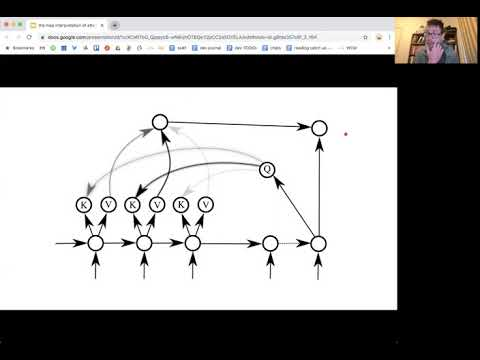

In [6]:
YT_V('7wMQgveLiQ4')

<a name='2.1'></a>
## 2.1 Dot product attention

We implement dot product attention which takes in a query, key, value, and a mask. It returns the output.

In the image above, a word can see everything that is before it, but not what is after it. To implement causal attention, you will have to transform vectors and do many reshapes. You will need to implement the functions below.

Functions that will be used to create tensors and display useful information:
   - `create_tensor`  creates a `jax numpy array` from a list of lists. [more on jaz numpy array](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.array.html)
   - `display_tensor` prints out the shape and the actual tensor.

In [ ]:
def create_tensor(t):
    """Create tensor from list of lists"""
    return jnp.array(t)


def display_tensor(t, name):
    """Display shape and tensor"""
    print(f'{name} shape: {t.shape}\n')
    print(f'{t}\n')

In [ ]:
# trax.fastmath.set_backend('jax') #or tensorflow-numpy

# # And this is how you set a TPU backend in Jax using Colab:
# # Add TPU Address to Globals

In [ ]:
# DotProductAttention
def DotProductAttention(query, key, value, mask):
    """Dot product self-attention.
    Args:
        query (jax.interpreters.xla.DeviceArray): array of query representations with shape (L_q by d)
        key (jax.interpreters.xla.DeviceArray): array of key representations with shape (L_k by d)
        value (jax.interpreters.xla.DeviceArray): array of value representations with shape (L_k by d) where L_v = L_k
        mask (jax.interpreters.xla.DeviceArray): attention-mask, gates attention with shape (L_q by L_k)

    Returns:
        jax.interpreters.xla.DeviceArray: Self-attention array for q, k, v arrays. (L_q by L_k)
    """

    assert query.shape[-1] == key.shape[-1] == value.shape[-1], "Embedding dimensions of q, k, v aren't all the same"

    # depth/dimension of the query embedding for scaling down the dot product
    depth = query.shape[-1]

    # Calculating scaled query key dot product according to formula above
    dots = jnp.matmul(query, jnp.swapaxes(key, -1, -2)) / jnp.sqrt(depth)

    # Apply the mask
    if mask is not None: # The 'None' in this line does not need to be replaced
        dots = jnp.where(mask, dots, jnp.full_like(dots, -1e9))
    #print(dots)
    # Softmax formula implementation
    # Use trax.fastmath.logsumexp of dots to avoid underflow by division by large numbers
    # Hint: Last axis should be used and keepdims should be True
    # Note: softmax = e^(dots - logsumexp(dots)) = E^dots / sumexp(dots)
    logsumexp = trax.fastmath.logsumexp(dots,axis=-1,keepdims=True)

    # Take exponential of dots minus logsumexp to get softmax
    # Useing jnp.exp()
    dots = jnp.exp(dots-logsumexp)

    # Multiply dots by value to get self-attention
    # Useing jnp.matmul()
    attention = jnp.matmul(dots,value)

    return attention

> The function first checks that the embedding dimensions of query, key, and value are all the same by using an assertion statement. The variable depth is then assigned the value of the last dimension of the query array. This value is used to scale down the dot product to avoid numerical instability issues.

> The dot product of the query and the transposed key arrays is then calculated and divided by the square root of the depth variable. If a mask is provided, it is applied to the dots array. The dots array is then passed through the softmax function to get the attention scores. The softmax function is implemented by first using the trax.fastmath.logsumexp() function to avoid underflow by division by large numbers. Finally, the attention scores are computed by taking the dot product of the attention scores and the value array.

<a name='2.2'></a>

## 2.2 Causal Attention

Implementing causal attention: multi-headed attention with a mask to attend only to words that occurred before.


The following 3 functions would normally be defined within the `CausalAttention` function further below.

* compute_attention_heads_closure
* dot_product_self_attention
* compute_attention_output

However this makes these functions harder to test. Because of this, these functions are shown individually using a `closure` (when necessary) that simulates them being inside of the `CausalAttention` function. This is done because they rely on some variables that can be accessed from within `CausalAttention`.

### Support Functions

<span style='color:blue'> compute_attention_heads </span>: Gets an input $x$ of dimension (batch_size, seqlen, n_heads $\times$ d_head) and splits the last (depth) dimension and stacks it to the zeroth dimension to allow matrix multiplication (batch_size $\times$ n_heads, seqlen, d_head).

**For the closures you only have to fill the inner function.**

In [ ]:
# compute_attention_heads:

# Compute_attention_heads_closure
# > It is a higher-order function that returns a compute_attention_heads specifed in the argument
def compute_attention_heads_closure(n_heads, dim_head):
    """ Function that simulates environment inside CausalAttention function.
    Args:
        n_heads (int): number of attention heads.
        dim_head (int):  dimensionality of heads.
    Returns:
        function: compute_attention_heads function
    """

    def compute_attention_heads(x):
        """ Compute the attention heads.
        Args:
            x (jax.interpreters.xla.DeviceArray): tensor with shape (batch_size, seqlen, n_heads X d_head).
        Returns:
            jax.interpreters.xla.DeviceArray: reshaped tensor with shape (batch_size X n_heads, seqlen, d_head).
        """
        # Size of the x's batch dimension
        batch_size = x.shape[0]
        # Length of the sequence
        len_seq = x.shape[1]
        # Reshape x using jnp.reshape()
        x = jnp.reshape(x,(batch_size, len_seq, n_heads, dim_head))
        # Transpose x using jnp.transpose
        x = jnp.reshape(x,(-1, len_seq, dim_head))

        return x

    return compute_attention_heads

> The purpose of this function is to reshape the input tensor x into a 3D tensor where the batch dimension is merged with the attention head dimension, so that attention can be computed across all the heads in parallel.

In [ ]:
# dot_product_self_attention :
# Creates a mask matrix with False values above the diagonal and True values below
# and calls DotProductAttention which implements dot product self attention.
def dot_product_self_attention(q, k, v):
    """ Masked dot product self attention.
    Args:
        q (jax.interpreters.xla.DeviceArray): queries.
        k (jax.interpreters.xla.DeviceArray): keys.
        v (jax.interpreters.xla.DeviceArray): values.
    Returns:
        jax.interpreters.xla.DeviceArray: masked dot product self attention tensor.
    """
    # mask size should be equal to L_q
    mask_size = q.shape[-2]

    # matrix with ones below the diagonal and 0s above.
    mask = jnp.tril(jnp.ones((1, mask_size, mask_size), dtype=jnp.bool_), k=0)

    return DotProductAttention(q, k, v, mask)

> The function creates a mask matrix of size mask_size with all elements initialized to 1 below the diagonal and 0 above the diagonal using jnp.tril function. This is because self-attention should only attend to tokens that come before the current token in the input sequence.

> The DotProductAttention function is then called with q, k, v, and the mask as input arguments to compute the masked dot product self-attention tensor which is then returned.

<span style='color:blue'> compute_attention_output </span>:

Undoes compute_attention_heads by splitting first (vertical) dimension and stacking in the last (depth) dimension (batch_size, seqlen, n_heads $\times$ d_head). These operations concatenate (stack/merge) the heads.

In [ ]:
# compute_attention_output :
# Undoes compute_attention_heads by splitting first (vertical) dimension and stacking in the last (depth) dimension (batch_size, seqlen, n_heads  ×  d_head). These operations concatenate (stack/merge) the heads.
def compute_attention_output_closure(n_heads, d_head):
    """ Function that simulates environment inside CausalAttention function.
    Args:
        d_head (int):  dimensionality of heads.
        n_heads (int): number of attention heads.
    Returns:
        function: compute_attention_output function
    """

    def compute_attention_output(x):
        """ Compute the attention output.
        Args:
            x (jax.interpreters.xla.DeviceArray): tensor with shape (batch_size X n_heads, seqlen, d_head).
        Returns:
            jax.interpreters.xla.DeviceArray: reshaped tensor with shape (batch_size, seqlen, n_heads X d_head).
        """
        # Length of the sequence
        seqlen = x.shape[1]

        # Reshaping x using jnp.reshape() to shape
        x = jnp.reshape(x,(-1, n_heads, seqlen, d_head))
        # Transposing x using jnp.transpose() to shape
        x = jnp.transpose(x,(0,2,1,3))

        # Reshape to allow to concatenate the heads
        return jnp.reshape(x, (-1, seqlen, n_heads * d_head))

    return compute_attention_output

> The function first reshapes the tensor x using jnp.reshape() to shape (-1, n_heads, seqlen, d_head), then transposes it using jnp.transpose() to shape (0,2,1,3). Finally, it reshapes the tensor again to allow concatenation of the heads to shape (-1, seqlen, n_heads * d_head) and returns it.

> Overall, this function is used to reverse the operation performed by the compute_attention_heads_closure() function, which concatenated the heads together before sending them through the attention mechanism.

### Causal Attention Function

Now it is time for you to put everything together within the `CausalAttention` or Masked multi-head attention function:

**Instructions:** Implement the causal attention.
Your model returns the causal attention through a $tl.Serial$ with the following:

- <span style='color:blue'> [tl.Branch](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Branch) </span>: consisting of 3 [tl.Dense(d_feature), ComputeAttentionHeads] to account for the queries, keys, and values.
- <span style='color:blue'> [tl.Fn](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.base.Fn)</span>: Takes in dot_product_self_attention function and uses it to compute the dot product using $Q$, $K$, $V$.
- <span style='color:blue'> [tl.Fn](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.base.Fn)</span>: Takes in compute_attention_output_closure to allow for parallel computing.
- <span style='color:blue'> [tl.Dense](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dense)</span>: Final Dense layer, with dimension `d_feature`.

Remember that in order for trax to properly handle the functions you just defined, they need to be added as layers using the [`tl.Fn()`](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.base.Fn) function.

In [ ]:
# CausalAttention
def CausalAttention(d_feature,
                    n_heads,
                    compute_attention_heads_closure=compute_attention_heads_closure,
                    dot_product_self_attention=dot_product_self_attention,
                    compute_attention_output_closure=compute_attention_output_closure,
                    mode='train'):

    """Transformer-style multi-headed causal attention.

    Args:
        d_feature (int):  dimensionality of feature embedding.
        n_heads (int): number of attention heads.
        compute_attention_heads_closure (function): Closure around compute_attention heads.
        dot_product_self_attention (function): dot_product_self_attention function.
        compute_attention_output_closure (function): Closure around compute_attention_output.
        mode (str): 'train' or 'eval'.

    Returns:
        trax.layers.combinators.Serial: Multi-headed self-attention model.
    """

    assert d_feature % n_heads == 0
    dim_head = d_feature // n_heads
    # Computing Functional Attention heads
    # function with the correct parameters to get the actual uncalled function.
    ComputeAttentionHeads = tl.Fn('AttnHeads', compute_attention_heads_closure(n_heads, dim_head), n_out=1)


    return tl.Serial(
        tl.Branch( # creating three towers for one input, takes activations and creates queries keys and values
            [tl.Dense(n_units=d_feature), ComputeAttentionHeads], # queries
            [tl.Dense(n_units=d_feature), ComputeAttentionHeads], # keys
            [tl.Dense(n_units=d_feature), ComputeAttentionHeads], # values
        ),

        tl.Fn('DotProductAttn', dot_product_self_attention, n_out=1), # takes QKV
        tl.Fn('AttnOutput', compute_attention_output_closure(n_heads, dim_head), n_out=1), # to allow for parallel
        tl.Dense(d_feature) # Final dense layer
    )

> The function returns a multi-headed self-attention model implemented using the Trax deep learning library.

> Inside this function, the code first checks then calculates dim_head which is the dimensionality of a single head. It then creates a ComputeAttentionHeads function which is a closure around the compute_attention_heads function and takes n_heads and dim_head as input.

> The attention model is implemented using the Trax Serial combinator. Inside this combinator, there are three branches. Each branch contains a Dense layer and a call to the ComputeAttentionHeads function. These branches are used to create queries, keys, and values, respectively.

> The output of each branch is then passed to the dot_product_self_attention function, which implements the dot product self-attention mechanism using the queries, keys, and values.

> The output of the self-attention mechanism is then passed to the compute_attention_output_closure function, which reshapes and concatenates the attention heads.

> Finally, the concatenated attention output is passed through a Dense layer with d_feature units to produce the final output of the model.

In [ ]:
# Preview
print(CausalAttention(d_feature=512, n_heads=8))

Serial[
  Branch_out3[
    [Dense_512, AttnHeads]
    [Dense_512, AttnHeads]
    [Dense_512, AttnHeads]
  ]
  DotProductAttn_in3
  AttnOutput
  Dense_512
]


---

<a name='2.3'></a>

## 2.3 Transformer decoder block

Implementing the causal part of the transformer

Image:
<img src = 'https://docs.google.com/uc?export=download&id=1GtTPbuNW3Qhqa0PJb9VfX1JUbxv1mb7t'>

We will call the `CausalAttention` or Masked multi-head attention function you implemented the transformer decoder block.

Adding a feedforward which consists of:

- <span style='color:blue'> [tl.LayerNorm](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.normalization.LayerNorm) </span>: used to layer normalize
- <span style='color:blue'> [tl.Dense](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dense) </span>: the dense layer
- <span style='color:blue'> [ff_activation](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.activation_fns.Relu) </span>: feed forward activation (we use ReLu) here.
- <span style='color:blue'> [tl.Dropout](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dropout) </span>: dropout layer
- <span style='color:blue'> [tl.Dense](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dense) </span>: dense layer
- <span style='color:blue'> [tl.Dropout](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dropout) </span>: dropout layer

After this we can go ahead and implement the entire block using:

- <span style='color:blue'> [tl.Residual](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Residual) </span>: takes in the tl.LayerNorm(), causal attention block, tl.dropout.

- <span style='color:blue'> [tl.Residual](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Residual) </span>: takes in the feedforward block you will implement.


In [ ]:
# DecoderBlock
def DecoderBlock(d_model, d_ff_n, n_heads,
                 dropout_rate, mode, ff_activation):
    """The function will return a list of layers that implements a Transformer decoder block.

    Activation tensor is input

    Args:
        d_model (int):  depth of embedding.
        d_ff (int): depth of feed-forward layer.
        n_heads (int): number of attention heads.
        dropout (float): dropout rate (how much to drop out).
        mode (str): 'train' or 'eval'.
        ff_activation (function): the non-linearity in feed-forward layer.

    Returns:
        list: list of trax.layers.combinators.Serial that maps an activation tensor to an activation tensor.
    """

    # A masked multi-head attention block using CausalAttention function
    causal_attention = CausalAttention(d_model, n_heads=n_heads, mode=mode)

    # Create feed-forward block
    # It is a list with individual steps
    # It consist of two dense layers with dropout and input normalized
    feed_forward = [
        # Normalizing layer inputs
        tl.LayerNorm(),
        # Adding first dense layer
        tl.Dense(d_ff_n),
        # Activation (Generally ReLU)
        ff_activation(),
        # Adding dropout
        tl.Dropout(rate=dropout_rate,mode=mode),
        # Adding second feed forward layer
        tl.Dense(d_model),
        # Adding dropout
        tl.Dropout(rate=dropout_rate,mode=mode)
    ]

    # Contains two layes one with attention with normalization and feed-forward blocks
    return [
      tl.Residual(
          # Normalizing layer input
          tl.LayerNorm(),
          # Adding causal attention block previously defined
          causal_attention,
          # Adding dropout with rate and mode specified
          tl.Dropout(rate=dropout_rate,mode=mode)
        ),
      tl.Residual(
          # Adding the feed forward block
          feed_forward
        ),
      ]

> The DecoderBlock function takes the hyperparameters required to build a decoder block for a Transformer model and returns a list of layers that implement the decoder block.

> The decoder block is composed of a masked multi-head attention block that uses the CausalAttention function and a feed-forward block. The feed-forward block is a list of two dense layers with ReLU activation, dropout, and input normalization.

> The masked multi-head attention block and feed-forward block are then wrapped inside two Residual blocks with layer normalization and dropout.

> The function takes the following arguments:

> * d_model: an integer representing the depth of the embedding.
> * d_ff_n: an integer representing the depth of the feed-forward layer.
> * n_heads: an integer representing the number of attention heads.
> * dropout_rate: a float representing the dropout rate.
> * mode: a string representing the mode of the decoder block, either "train" or "eval".
> * ff_activation: a function representing the non-linearity in the feed-forward layer.

> The function then returns a list of layers that implement the decoder block.

In [ ]:
# Testing
print(DecoderBlock(d_model=512, d_ff_n=2048, n_heads=8, dropout_rate=0.1, mode='train', ff_activation=tl.Relu))

[Serial[
  Branch_out2[
    None
    Serial[
      LayerNorm
      Serial[
        Branch_out3[
          [Dense_512, AttnHeads]
          [Dense_512, AttnHeads]
          [Dense_512, AttnHeads]
        ]
        DotProductAttn_in3
        AttnOutput
        Dense_512
      ]
      Dropout
    ]
  ]
  Add_in2
], Serial[
  Branch_out2[
    None
    Serial[
      LayerNorm
      Dense_2048
      Serial[
        Relu
      ]
      Dropout
      Dense_512
      Dropout
    ]
  ]
  Add_in2
]]


<a name='2.4'></a>
## 2.4 Transformer Language Model

Building the tranformer language Model. We will use all fuctions/components we built above

**Building the model:**

We will be using the following:

- <span style="color:blue"> positional_enconder </span>- a list containing the following layers:
    - <span style="color:blue"> [tl.Embedding](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Embedding)
    - <span style="color:blue"> [tl.Dropout](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dropout)
    - <span style="color:blue"> [tl.PositionalEncoding](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.attention.PositionalEncoding)

- A list of `n_layers` <span style="color:blue"> decoder blocks</span>.
- <span style="color:blue"> [tl.Serial](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Serial): </span> takes in the following layers or lists of layers:
    - <span style="color:blue"> [tl.ShiftRight](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.attention.ShiftRight): </span>: shift the tensor to the right by padding on axis 1.
    - <span style="color:blue"> positional_encoder </span>: encodes the text positions.
    - <span style="color:blue"> decoder_blocks </span>: the ones you created.
    - <span style="color:blue"> [tl.LayerNorm](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.normalization.LayerNorm) </span>: a layer norm.
    - <span style="color:blue"> [tl.Dense](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dense) </span>: takes in the vocab_size.
    - <span style="color:blue"> [tl.LogSoftmax](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.LogSoftmax) </span>: to predict.




In [ ]:
# # import requests
# trax.fastmath.set_backend('jax') #or tensorflow-numpy

# # And this is how you set a TPU backend in Jax using Colab:
# # Add TPU Address to Globals

KeyError: ignored

In [ ]:
# TransformerLM
def TransformerLM(vocab_size=33300,
                  d_model=512,
                  d_ff=2048,
                  n_layers=6,
                  n_heads=8,
                  dropout=0.1,
                  max_len=4096,
                  mode='train',
                  ff_activation=tl.Relu):
    """Returns a Transformer language model.

    The input to the model is a tensor of tokens. (This model uses only the
    decoder part of the overall Transformer.)

    Args:
        vocab_size (int): vocab size.
        d_model (int):  depth of embedding.
        d_ff (int): depth of feed-forward layer.
        n_heads (int): the no. of attention heads.
        n_layers (int): the no. of decoder layers.
        dropout (float): dropout rate (how much to drop out).
        max_len (int): maximum symbol length for positional encoding.
        mode (str): 'train', 'eval' or 'predict', predict mode is for fast inference.
        ff_activation (function): the non-linearity in feed-forward layer.

    Returns:
        trax.layers.combinators.Serial: A Transformer language model as a layer that maps from a tensor of tokens
        to activations over a vocab set.
    """

    # Embedding inputs and positional encoder
    positional_encoder = [
        # Adding embedding layer
        tl.Embedding(vocab_size,d_model),
        # Using dropout with rate and mode specified
        tl.Dropout(rate=dropout,mode=mode),
        # Adding positional encoding layer
        tl.PositionalEncoding(max_len=max_len,mode=mode)]

    # A stack list of decoder blocks
    decoder_blocks = [DecoderBlock(d_model, d_ff, n_heads, dropout, mode, ff_activation) for _ in range(n_layers)]

    # Final complete model
    return tl.Serial(
        # feed output of previous step to current step
        tl.ShiftRight(n_positions=1,mode=mode), # Specify the mode!
        # Adding positional encoder
        positional_encoder,
        # Adding decoder blocks
        decoder_blocks,
        # Normalizing the layer
        tl.LayerNorm(),

        # Adding a dense layer
        tl.Dense(vocab_size),
        # Geting probabilities with Logsoftmax
        tl.LogSoftmax()
    )


In [ ]:
# Testing
print(TransformerLM(n_layers=1))  ## input [batch,T] , output [b,T,vocab_size]

Serial[
  Serial[
    ShiftRight(1)
  ]
  Embedding_33300_512
  Dropout
  PositionalEncoding
  Serial[
    Branch_out2[
      None
      Serial[
        LayerNorm
        Serial[
          Branch_out3[
            [Dense_512, AttnHeads]
            [Dense_512, AttnHeads]
            [Dense_512, AttnHeads]
          ]
          DotProductAttn_in3
          AttnOutput
          Dense_512
        ]
        Dropout
      ]
    ]
    Add_in2
  ]
  Serial[
    Branch_out2[
      None
      Serial[
        LayerNorm
        Dense_2048
        Serial[
          Relu
        ]
        Dropout
        Dense_512
        Dropout
      ]
    ]
    Add_in2
  ]
  LayerNorm
  Dense_33300
  LogSoftmax
]


---

<a name='3'></a>
# Part 3: Training

Training the model.
Defining the cost function, the optimizer. In this case, we will train your model on a cpu for a few steps.

<a name='3.1'></a>
### 3.1 Training Setup

Function that takes in the model and trains it.

<a name='ex05'></a>

**Steps:** Implementing the `train_model` to train the neural network above.

- Train task by calling [`trax.supervised.training.TrainTask`](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html#trax.supervised.training.TrainTask) and pass in the following:
    - <span style='color:blue'> labeled_data </span> = train_gen
    - <span style='color:blue'> loss_fn </span> = [tl.CrossEntropyLoss()](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.metrics.CrossEntropyLoss)
    - <span style='color:blue'> optimizer </span> = [trax.optimizers.Adam(0.01)](https://trax-ml.readthedocs.io/en/latest/trax.optimizers.html#trax.optimizers.adam.Adam)
    - <span style='color:blue'> lr_schedule </span> = [lr_schedule](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html#trax.supervised.lr_schedules.warmup_and_rsqrt_decay)


- Evaluate task by calling [`trax.supervised.training.EvalTask`](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html#trax.supervised.training.EvalTask) and pass in the following:
    - <span style='color:blue'> labeled_data </span> = eval_gen
    - <span style='color:blue'> metrics </span> = tl.CrossEntropyLoss() and [tl.Accuracy()](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.metrics.Accuracy)


- Training loop by calling [`trax.supervised.Training.Loop`](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html#trax.supervised.training.Loop) and pass in the following:
    - <span style='color:blue'> TransformerLM </span>
    - <span style='color:blue'> train_task </span>
    - <span style='color:blue'> eval_task </span> = [eval_task]
    - <span style='color:blue'> output_dir</span> = output_dir

You will be using a cross entropy loss, with Adam optimizer. More information on can be found on [Trax](https://trax-ml.readthedocs.io/en/latest/index.html) documentation to get a full understanding.

The training loop that this function returns can be runned using the `run()` method by passing in the desired number of steps.

In [ ]:
from trax.supervised import training

# train_model
def training_loop(Transformer_model, data_stream, test_gen, n_steps_per_checkpoint: int = 10, model_dir: str = "model/summary_transformer_model"):
  '''
  Input:
      TransformerLM (trax.layers.combinators.Serial): The model you are building.
      data_stream (generator): Training stream of data.
      test_gen (generator): Evaluation stream of data.
      n_steps_per_checkpoint (int): Number of steps per checkpoint
      model_dir (str): folder to save your file.

  Returns:
      trax.supervised.training.Loop: Training loop.
  '''
  model_dir = os.path.expanduser(model_dir)  # trainer is an object
  lr_schedule = trax.lr.warmup_and_rsqrt_decay(n_warmup_steps=1000, max_value=0.01)

  # Train Task
  # labeled data from training generator
  # Loss function as CrossEntropyLoss
  # Optimizer as Adam with learning rate 0.01
  train_task = training.TrainTask(
    labeled_data=data_stream, # data from training generator
    loss_layer=tl.CrossEntropyLoss(), # Loss function
    optimizer=trax.optimizers.Adam(0.01), # Optimizer (Don't forget to set LR to 0.01)
    lr_schedule=lr_schedule, # Something you need
    n_steps_per_checkpoint= n_steps_per_checkpoint
  )

  # Evaluate Task
  # The evaluation generator
  # CrossEntropyLoss and Accuracy
  test_task = training.EvalTask(labeled_data=test_gen, metrics=[tl.CrossEntropyLoss(), tl.Accuracy()])

  loop = training.Loop(Transformer_model, train_task, eval_tasks=[test_task], output_dir=model_dir)

  return loop

The model will be trained for only 10 steps.

Even with this constraint the model with the original default arguments took a very long time to finish. Due to this some parameters are changed when defining the model that is fed into the training loop in the function above.

In [ ]:
# Create DIR
create_directory('/content/model')

In [ ]:
# Downloading model
!wget 'https://docs.google.com/uc?export=download&id=1H8lMO5bd__2OIa3sEHXKxqJEi265B3J4&confirm=t' -O '/content/model/summary_transformer_model_v1.zip'

--2023-05-04 04:12:41--  https://docs.google.com/uc?export=download&id=1H8lMO5bd__2OIa3sEHXKxqJEi265B3J4&confirm=t
Resolving docs.google.com (docs.google.com)... 74.125.137.138, 74.125.137.139, 74.125.137.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.137.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-40-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8c3h5cctlngfkm957p2uugf7810re8vc/1683173550000/08128782292317104630/*/1H8lMO5bd__2OIa3sEHXKxqJEi265B3J4?e=download&uuid=14353ea1-8a65-43a9-ab50-aa701b78d721 [following]
--2023-05-04 04:12:43--  https://doc-00-40-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8c3h5cctlngfkm957p2uugf7810re8vc/1683173550000/08128782292317104630/*/1H8lMO5bd__2OIa3sEHXKxqJEi265B3J4?e=download&uuid=14353ea1-8a65-43a9-ab50-aa701b78d721
Resolving doc-00-40-docs.googleusercontent.com (doc-00-40-docs.googleusercontent.com)... 142.250.101.132,

In [ ]:
# Model
# Model Training

# Control
model_version_nm = 'summary_transformer_model_v1'
steps = 1000
create = False
n_steps_per_checkpoint = 100

# Version Control
model_path = '/content/model'

model_dir = os.path.join(model_path, model_version_nm)



# create_directory(model_dir)
create_directory(model_dir)

# Creating a fresh model
New_transformer = TransformerLM(vocab_size=2000, d_model=32, d_ff=256, n_layers=3, n_heads=8, dropout=0.1, max_len=2048, ff_activation = tl.Relu)

# Training
loop = training_loop(New_transformer, train_batch_stream, test_batch_stream, n_steps_per_checkpoint = n_steps_per_checkpoint, model_dir = model_dir )

if not(create):
  # unzip
  unzip_file(f'{model_dir}.zip')
  # Load
  loop.model.init_from_file(f'{model_dir}/model.pkl.gz', weights_only=True)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/jax/_src/xla_bridge.py:658: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  warnings.warn(


In [ ]:
# Loading trained model

# Create or load


# unzip
unzip_file(f'{model_dir}.zip')

# Load the pre-trained weights
New_transformer.init_from_file(f'{model_dir}/model.pkl.gz', weights_only=True)
model

<a name='3.2'></a>
### 3.2 Training the Model

In [ ]:
# Model Training
additional_steps = 2000

loop.run(additional_steps)


Step   6020: Ran 10 train steps in 25.27 secs
Step   6020: train CrossEntropyLoss |  2.83537626
Step   6020: eval  CrossEntropyLoss |  3.16935253
Step   6020: eval          Accuracy |  0.07843138

Step   6030: Ran 10 train steps in 23.18 secs
Step   6030: train CrossEntropyLoss |  2.94593930
Step   6030: eval  CrossEntropyLoss |  2.34274578
Step   6030: eval          Accuracy |  0.11111111

Step   6040: Ran 10 train steps in 24.83 secs
Step   6040: train CrossEntropyLoss |  2.85485029
Step   6040: eval  CrossEntropyLoss |  2.66719866
Step   6040: eval          Accuracy |  0.13970588

Step   6050: Ran 10 train steps in 22.41 secs
Step   6050: train CrossEntropyLoss |  3.00162959
Step   6050: eval  CrossEntropyLoss |  2.88957810
Step   6050: eval          Accuracy |  0.08682635

Step   6060: Ran 10 train steps in 21.18 secs
Step   6060: train CrossEntropyLoss |  2.97003365
Step   6060: eval  CrossEntropyLoss |  2.67711949
Step   6060: eval          Accuracy |  0.12280702

Step   6070: R

In [ ]:
# Saving
# Zip and Download
zip_n_dl(model_dir)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Additional Training:
additional_steps = 2000
loop.run(additional_steps)


Step   8020: Ran 10 train steps in 22.86 secs
Step   8020: train CrossEntropyLoss |  2.84446287
Step   8020: eval  CrossEntropyLoss |  2.84076333
Step   8020: eval          Accuracy |  0.07563026

Step   8030: Ran 10 train steps in 26.98 secs
Step   8030: train CrossEntropyLoss |  2.89877772
Step   8030: eval  CrossEntropyLoss |  2.84172583
Step   8030: eval          Accuracy |  0.08888889

Step   8040: Ran 10 train steps in 25.69 secs
Step   8040: train CrossEntropyLoss |  2.85345316
Step   8040: eval  CrossEntropyLoss |  3.31788206
Step   8040: eval          Accuracy |  0.10714286

Step   8050: Ran 10 train steps in 25.15 secs
Step   8050: train CrossEntropyLoss |  2.72076464
Step   8050: eval  CrossEntropyLoss |  3.16182280
Step   8050: eval          Accuracy |  0.10714286

Step   8060: Ran 10 train steps in 22.76 secs
Step   8060: train CrossEntropyLoss |  2.78029776
Step   8060: eval  CrossEntropyLoss |  2.78838396
Step   8060: eval          Accuracy |  0.08965518

Step   8070: R

In [ ]:
# Saving
# Zip and Download
zip_n_dl(model_dir)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

 <a name='4'></a>
 # Part 4:  Evaluation

<a name='4.1'></a>
### 4.1 Loading in a trained model

Evaluating the model.

In [ ]:
[x for x in dir(loop) if not(str(x).startswith('_'))]

['eval_model',
 'eval_tasks',
 'history',
 'is_chief',
 'load_checkpoint',
 'log_summary',
 'model',
 'n_devices',
 'new_rng',
 'output_dir',
 'run',
 'run_evals',
 'save_checkpoint',
 'step',
 'tasks',
 'update_weights_and_state']

In [ ]:
# Fetching Model

model = loop.model

In [ ]:
# # Fetching Model

# # Get the model architecture
# model = TransformerLM(mode='eval')

# # Load the pre-trained weights
# model.init_from_file('/root/model/model.pkl.gz', weights_only=True)
# model

<a name='5'></a>
# Part 5: Testing

Testing the model.

Implementing a greedy decoding code. It will consists of two parts.

The first part will identify the next symbol. It does it by calculating the argmax of the output of the model and will returns the index.


In [ ]:
def next_symbol(output_tokens, model):
  """Returns the next symbol for a given sentence.

  Args:
      output_tokens (list): tokenized sentence with EOS and PAD tokens at the end.
      model (trax.layers.combinators.Serial): The Transformer model.

  Returns:
      int: tokenized symbol.
  """
  # current output tokens length
  token_length = len(output_tokens)
  #print(f'padded length: {token_length}')

  # calculating the minimum power of 2 big enough to store token_length
  padded_length = 2**int(np.ceil(np.log2(token_length + 1)))
  #print(f'padded length: {padded_length}')

  # Padding output_tokens with 0's
  padded = output_tokens + [0] * (padded_length - token_length)
  padded_with_batch = np.array(padded)[None, :]

  # model consumes a tuple containing two padded tensors with batch
  output, _ = model((padded_with_batch, padded_with_batch))
  # token_length in the second dim and all of the entries for the last dim.
  log_probs = output[0, token_length, :]

  return int(np.argmax(log_probs))

In [ ]:
# Testing
sentence_test_nxt_symbl = "Before the times of GPS and cell phones, maps were the main way to find one's way from point A to point B without getting lost. Nowadays, we have maps for everything from land elevation to animal location origins. Maps are fantastic things, just ask the cartographer at the local map store, he'll be sure to feel the same way. So if you're ready to take a look at 40 of the most interesting maps of America, keep reading!"
detokenizer([next_symbol(tokenizer(sentence_test_nxt_symbl)+[0], model)])

'The'

---

<a name='5.1'></a>
### 5.1 Greedy decoding

Implementing the greedy_decode algorithm that will call the `next_symbol` function.

Input:
* input_sentence
* the trained model

Returns
* decoded sentence.


In [ ]:
# Decoding functions.
def greedy_decode(input_text, model, max_n = 100, show_progress = False):
  """Greedy decode function.
  Args:
      input_text (string): a sentence or article.
      model (trax.layers.combinators.Serial): Transformer model.
      max_n (int): Max number of tokens limit
      show_progress (Bool): To show output after each word generation

  Returns:
      string: summary of the input.
  """

  # Using tokenizer()
  processed_text = process_text(input_text)
  cur_output_tokens = tokenizer(processed_text) + [0]
  generated_output = []
  cur_output = 0
  EOS = 1
  i = 0
  l_t_len = 0

  if show_progress:
    print('GENERATING SUMMARY:')

  while cur_output != EOS and (i < max_n or max_n == 0):
    # Get next symbol
    cur_output = next_symbol(cur_output_tokens, model)
    # Appending next symbol to original sentence
    cur_output_tokens.append(cur_output)
    # Appending next symbol to generated sentence
    generated_output.append(cur_output)
    text_gen = detokenizer(generated_output)
    if show_progress:
      clear_text = "\b" * l_t_len + " " * l_t_len + "\b" * l_t_len
      print(clear_text, end="", flush=True)
      print(f'{text_gen}....({i})',end="", flush=True)
      l_t_len = len(text_gen) + len(f'....({i})')
    # Incrementing
    i += 1

  print('\n -------------- \n')
  return text_gen

In [ ]:
# Test it out on a sentence!
test_sentence = "Before the times of GPS and cell phones, maps were the main way to find one's way from point A to point B without getting lost. Nowadays, we have maps for everything from land elevation to animal location origins. Maps are fantastic things, just ask the cartographer at the local map store, he'll be sure to feel the same way. So if you're ready to take a look at 40 of the most interesting maps of America, keep reading!"
print(wrapper.fill(test_sentence), '\n')
print(greedy_decode(test_sentence, model, 50, show_progress=True))

Before the times of GPS and cell phones, maps were the main way to
find one's way from point A to point B without getting lost. Nowadays,
we have maps for everything from land elevation to animal location
origins. Maps are fantastic things, just ask the cartographer at the
local map store, he'll be sure to feel the same way. So if you're
ready to take a look at 40 of the most interesting maps of America,
keep reading! 

GENERATING SUMMARY:
The....(0)          The U....(1)            The U.....(2)             The U.S....(3)              The U.S.....(4)               The U.S. The....(5)                   The U.S. The U....(6)                     The U.S. The U.....(7)                      The U.S. The U.S....(8)      

In [ ]:
# Test it out with a whole article!
article = "It’s the posing craze sweeping the U.S. after being brought to fame by skier Lindsey Vonn, soccer star Omar Cummings, baseball player Albert Pujols - and even Republican politician Rick Perry. But now four students at Riverhead High School on Long Island, New York, have been suspended for dropping to a knee and taking up a prayer pose to mimic Denver Broncos quarterback Tim Tebow. Jordan Fulcoly, Wayne Drexel, Tyler Carroll and Connor Carroll were all suspended for one day because the ‘Tebowing’ craze was blocking the hallway and presenting a safety hazard to students. Scroll down for video. Banned: Jordan Fulcoly, Wayne Drexel, Tyler Carroll and Connor Carroll (all pictured left) were all suspended for one day by Riverhead High School on Long Island, New York, for their tribute to Broncos quarterback Tim Tebow. Issue: Four of the pupils were suspended for one day because they allegedly did not heed to warnings that the 'Tebowing' craze at the school was blocking the hallway and presenting a safety hazard to students."
print(wrapper.fill(article), '\n')
print(greedy_decode(test_sentence, model, 50, show_progress=True))

It’s the posing craze sweeping the U.S. after being brought to fame by
skier Lindsey Vonn, soccer star Omar Cummings, baseball player Albert
Pujols - and even Republican politician Rick Perry. But now four
students at Riverhead High School on Long Island, New York, have been
suspended for dropping to a knee and taking up a prayer pose to mimic
Denver Broncos quarterback Tim Tebow. Jordan Fulcoly, Wayne Drexel,
Tyler Carroll and Connor Carroll were all suspended for one day
because the ‘Tebowing’ craze was blocking the hallway and presenting a
safety hazard to students. Scroll down for video. Banned: Jordan
Fulcoly, Wayne Drexel, Tyler Carroll and Connor Carroll (all pictured
left) were all suspended for one day by Riverhead High School on Long
Island, New York, for their tribute to Broncos quarterback Tim Tebow.
Issue: Four of the pupils were suspended for one day because they
allegedly did not heed to warnings that the 'Tebowing' craze at the
school was blocking the hallway and presen

In [ ]:
article='The success of modern farming and plant breeding relies on accurate and efficient collection of data. For a commercial organization that manages large amounts of crops, collecting accurate and consistent data is a bottleneck. Due to limited time and labor, accurately phenotyping crops to record color, head count, height, weight, etc. is severely limited. However, this information, combined with other genetic and environmental factors, is vital for developing new superior crop species that help feed the world’s growing population. Recent advances in machine learning, in particular deep learning, have shown promise in mitigating this bottleneck. In this paper, we propose a novel deep learning method for counting on-ear corn kernels in-field to aid in the gathering of real-time data and, ultimately, to improve decision making to maximize yield. We name this approach DeepCorn, and show that this framework is robust under various conditions. DeepCorn estimates the density of corn kernels in an image of corn ears and predicts the number of kernels based on the estimated density map.'

print(wrapper.fill(article), '\n')
print(greedy_decode(test_sentence, model, 50, show_progress=True))

The success of modern farming and plant breeding relies on accurate
and efficient collection of data. For a commercial organization that
manages large amounts of crops, collecting accurate and consistent
data is a bottleneck. Due to limited time and labor, accurately
phenotyping crops to record color, head count, height, weight, etc. is
severely limited. However, this information, combined with other
genetic and environmental factors, is vital for developing new
superior crop species that help feed the world’s growing population.
Recent advances in machine learning, in particular deep learning, have
shown promise in mitigating this bottleneck. In this paper, we propose
a novel deep learning method for counting on-ear corn kernels in-field
to aid in the gathering of real-time data and, ultimately, to improve
decision making to maximize yield. We name this approach DeepCorn, and
show that this framework is robust under various conditions. DeepCorn
estimates the density of corn kernels in

In [ ]:
article='A convicted sex offender this week fatally shot his wife and her three children in their Oklahoma home – as well as two teenage girls who there were for a sleepover – before killing himself, police said Wednesday, accounting for the bodies’ discovery days earlier. Authorities found the bodies Monday at a property in Henryetta, a city about 90 miles from Oklahoma City, where 39-year-old registered sex offender Jesse L. McFadden lived with his wife, 35-year-old Holly McFadden, and her children, who were McFadden’s stepchildren: Rylee Allen, 17; Michael Mayo, 15; and Tiffany Guess, 13. The two other teen girls who were killed – 14-year-old Ivy Webster and 16-year-old Brittany Brewer – had been reported missing and in danger on Monday morning. The girls were Tiffany’s friends and spent the night with her on Saturday, and they were reported missing when they didn’t return home Sunday as planned, Okmulgee Police Chief Joe Prentice said. 16-year-old Brittany Brewer, left, and 14-year-old Ivy Webster, right, were the subject of an endangered/missing advisory issued by the Oklahoma Highway Patrol, which said they were last seen early Monday morning in Henryetta. A convicted sex offender and 2 teenage girls believed among 7 bodies found at his Oklahoma home “I follow the evidence … and the evidence is that Jesse McFadden murdered six people and then killed himself,” Prentice said during a news conference Wednesday. “I don’t have any evidence to indicate what the actual motive was.” The bodies of Holly and two of her children – Michael and Tiffany – were found together outside on the property, which the McFaddens were renting, Prentice said. The bodies of Ivy, Brittany and Rylee were found separately, about 150 yards apart from each other, he added. The scene “appeared to be staged,” the chief said, adding he believes the victims’ bodies were moved after they were killed. “There are questions that will never get answered because the only people who know are no longer here,” Prentice said. “We will continue to document everything that we have found and anything that we discover in follow-up interviews moving forward, and generate a report. We will submit that report to the district attorney’s office for her review as a formality, because there is no prosecution to be had here.” The firearm used in the killings was a handgun that Holly bought in 2022, Prentice said. Holly’s mother, Janette Mayo, told CNN affiliate KJRH in an on-air interview that her daughter was married to McFadden. She identified Holly and Holly’s three children as four of the victims.'

print(wrapper.fill(article), '\n')
print(greedy_decode(test_sentence, model, 50, show_progress=True))

A convicted sex offender this week fatally shot his wife and her three
children in their Oklahoma home – as well as two teenage girls who
there were for a sleepover – before killing himself, police said
Wednesday, accounting for the bodies’ discovery days earlier.
Authorities found the bodies Monday at a property in Henryetta, a city
about 90 miles from Oklahoma City, where 39-year-old registered sex
offender Jesse L. McFadden lived with his wife, 35-year-old Holly
McFadden, and her children, who were McFadden’s stepchildren: Rylee
Allen, 17; Michael Mayo, 15; and Tiffany Guess, 13. The two other teen
girls who were killed – 14-year-old Ivy Webster and 16-year-old
Brittany Brewer – had been reported missing and in danger on Monday
morning. The girls were Tiffany’s friends and spent the night with her
on Saturday, and they were reported missing when they didn’t return
home Sunday as planned, Okmulgee Police Chief Joe Prentice said.
16-year-old Brittany Brewer, left, and 14-year-old Ivy 

---

---